## Custom Optimizer SGD in Pytorch

In [ ]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CustomOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        # Define default hyperparameters
        defaults = dict(lr=lr)
        super(CustomOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        # Optional closure for reevaluating the model (e.g., for line search)
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Iterate over parameter groups
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # Simple gradient descent step
                p.add_(p.grad, alpha=-lr)
                #p.data = p.data - lr * p.grad
        return loss

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

In [ ]:
model = TwoLayerNet(5, 2, 1)
optimizer = CustomOptimizer(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [ ]:
x = torch.randn(32, 5)
y = torch.randn(32, 1)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)

optimizer.zero_grad()
loss.backward()

In [ ]:
before = model.fc1.weight.clone()
optimizer.step()
after = model.fc1.weight
print(before, after)

In [ ]:
print(len(optimizer.param_groups))
print()
print(optimizer.param_groups[0])
print()
print(optimizer.param_groups[0].keys())
print()
print(optimizer.param_groups[0]['lr'])
print()
print(optimizer.param_groups[0]['params'])
print()
print(len(optimizer.param_groups[0]['params']))
print()
print(optimizer.param_groups[0]['params'][0])
print(optimizer.param_groups[0]['params'][1])
print()
print(optimizer.param_groups[0]['params'][0].grad)
print(optimizer.param_groups[0]['params'][1].grad)

## Custom Adam Optimizer

In [ ]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CustomAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid lr: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid eps: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                # State initialization
                state = self.state[p]
                if not state:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                # Update biased first moment estimate
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update biased second raw moment estimate
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Compute bias-corrected moments
                bias_correction1 = 1 - beta1 ** t
                bias_correction2 = 1 - beta2 ** t
                corrected_avg = exp_avg / bias_correction1
                corrected_avg_sq = exp_avg_sq / bias_correction2

                # Parameter update
                denom = corrected_avg_sq.sqrt().add_(eps)
                p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

In [ ]:
model = TwoLayerNet(5, 2, 1)
optimizer = CustomAdam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = torch.nn.MSELoss()

In [ ]:
x = torch.randn(32, 5)
y = torch.randn(32, 1)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)

optimizer.zero_grad()
loss.backward()

In [ ]:
before = model.fc1.weight.clone()
optimizer.step()
after = model.fc1.weight
print(before, after)

In [ ]:
print(len(optimizer.param_groups))
print()
print(optimizer.param_groups[0])
print()
print(optimizer.param_groups[0].keys())
print()
print(optimizer.param_groups[0]['lr'])
print()
print(optimizer.param_groups[0]['params'])
print()
print(len(optimizer.param_groups[0]['params']))
print()
print(optimizer.param_groups[0]['params'][0])
print(optimizer.param_groups[0]['params'][1])
print()
print(optimizer.param_groups[0]['params'][0].grad)
print(optimizer.param_groups[0]['params'][1].grad)

# Flora

## Flora Helper Functions

In [7]:
import contextlib
import logging
import math
from functools import partial
from typing import Any, Callable, Dict, Generator, Iterable, Optional, Sequence, Union
import torch
from torch.optim.optimizer import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def stable_randn(
    shape: Union[int, Sequence[int]],
    seed: int,
    device: Optional[Union[str, torch.device]] = None,
    dtype: Optional[torch.dtype] = torch.float32,
) -> torch.Tensor:
    if device is None:
        device = torch.device("cpu")
    generator = torch.Generator(device=device).manual_seed(seed)
    rn = torch.randn(shape, generator=generator, device=generator.device, dtype=dtype)
    return rn

In [9]:
def next_seed(seed: int, adv: int = 0xF) -> int:
    """
    This is a naive helper function to generate a new seed from the given seed.
    """
    generator = torch.Generator().manual_seed(seed)
    return torch.randint(
        0, torch.iinfo(torch.int64).max, (adv,), generator=generator, device=generator.device
    ).tolist()[-1]

In [10]:
def split_seed(seed: int) -> tuple[int, int]:
    generator = torch.Generator().manual_seed(seed)
    return tuple(
        torch.randint(0, torch.iinfo(torch.int64).max, (2,), generator=generator, device=generator.device).tolist()
    )

In [11]:
enable_logging = True
def fprint(*args):
  if enable_logging:
    print(*args)

## 2 Types of Flora

In [ ]:
# @title Flora Adam

class FloraAdam(Optimizer):
    def __init__(
        self,
        params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
        lr:float = None,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        rank: int = None,
        kappa: int = 1000,
        seed: int = 0,
    ) -> None:

        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "rank": rank,
            "kappa": kappa,

        }
        super().__init__(params, defaults)

        params_idx = seed
        for group in self.param_groups:
            for p in group["params"]:
                params_idx += 1
                if p.requires_grad:
                    self.state[p]["seed"] = params_idx

    @staticmethod
    def _should_compress(param_group: Dict, param_shape: tuple[int, ...]) -> bool:
        factored = len(param_shape) == 2
        should_compress= (
            param_group["rank"] is not None
            and param_group["rank"] > 0
            and factored
            and min(param_shape) >= param_group["rank"]
            and max(param_shape) / min(param_shape) <= 4  # rule out embeddings
        )
        return should_compress

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                grad_shape = grad.shape
                should_compress = optimizer._should_compress(group, grad_shape)

                fprint('\n', 'grad_shape =', grad_shape)
                fprint('should_compress =', should_compress)

                state = self.state[p]

                # State initialization
                if (state and'step' not in state) or (not state):
                    state['step'] = 0

                    if should_compress:
                        if grad_shape[0] < grad_shape[-1]:
                            cshape = (group["rank"], grad_shape[-1])
                        else:
                            cshape = (grad_shape[0], group["rank"])

                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros(cshape).to(grad)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                    else:
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                if should_compress:
                    def _down_proj(seed, rank, tensor):
                        lseed, rseed = split_seed(seed)
                        if tensor.shape[0] < tensor.shape[-1]:
                            left_projection = stable_randn(
                                (rank, tensor.shape[0]),
                                seed=lseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)

                            return left_projection @ tensor
                        else:
                            right_projection = stable_randn(
                                (tensor.shape[-1], rank),
                                seed=rseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)
                        return tensor @ right_projection

                    def _up_proj(seed, rank, shape, ctensor):
                        lseed, rseed = split_seed(seed)
                        if shape[0] < shape[-1]:
                            left_projection = stable_randn(
                                (rank, shape[0]),
                                seed=lseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return left_projection.t() @ ctensor
                        else:
                            right_projection = stable_randn(
                                (shape[-1], rank),
                                seed=rseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return ctensor @ right_projection.t()

                    _current_seed = state["seed"]

                    cgrad = _down_proj(seed=_current_seed, rank=group["rank"], tensor=grad)
                    fprint('cgrad =', cgrad.shape)
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(cgrad, alpha=1 - beta1)
                    fprint('exp_avg =', exp_avg.shape)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                    fprint('exp_avg_sq =', exp_avg_sq.shape)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)

                    fprint('Decompr corrected_avg =', _up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg).shape)

                    p.addcdiv_(_up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg),
                              denom,
                              value=-lr)

                    # Time for a new seed
                    if state["step"] % group["kappa"] == 0:
                        _next_seed = next_seed(state["seed"])
                        fprint('Setting the new seed =', _next_seed)

                        state["exp_avg"].copy_(
                            _down_proj(
                                seed=_next_seed,
                                rank=group["rank"],
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=group["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                    ),
                            )
                        )

                        state["seed"] = _next_seed
                        _current_seed = _next_seed

                else:
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)
                    p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss

In [ ]:
# @title Flora Adam with Decreasing Rank

class FloraAdamD(Optimizer):
    def __init__(
        self,
        params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
        lr:float = None,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        rank: int = None,
        kappa: int = 1000,
        seed: int = 0,
    ) -> None:

        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "rank": rank,
            "kappa": kappa,

        }
        super().__init__(params, defaults)

        params_idx = seed
        for group in self.param_groups:
            for p in group["params"]:
                params_idx += 1
                if p.requires_grad:
                    self.state[p]["seed"] = params_idx

    @staticmethod
    def _should_compress(param_group: Dict, param_shape: tuple[int, ...]) -> bool:
        factored = len(param_shape) == 2
        should_compress= (
            param_group["rank"] is not None
            and param_group["rank"] > 0
            and factored
            and min(param_shape) >= param_group["rank"]
            and max(param_shape) / min(param_shape) <= 4  # rule out embeddings
        )
        return should_compress

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                grad_shape = grad.shape
                should_compress = optimizer._should_compress(group, grad_shape)

                fprint('\n', 'grad_shape =', grad_shape)
                fprint('should_compress =', should_compress)

                state = self.state[p]

                # State initialization
                if (state and'step' not in state) or (not state):
                    state['step'] = 0

                    if should_compress:
                        if grad_shape[0] < grad_shape[-1]:
                            cshape = (group["rank"], grad_shape[-1])
                        else:
                            cshape = (grad_shape[0], group["rank"])

                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros(cshape).to(grad)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)
                        # Assign the Rank to the state also
                        state['rank'] = group["rank"]

                    else:
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                if should_compress:
                    def _down_proj(seed, rank, tensor):
                        lseed, rseed = split_seed(seed)
                        if tensor.shape[0] < tensor.shape[-1]:
                            left_projection = stable_randn(
                                (rank, tensor.shape[0]),
                                seed=lseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)

                            return left_projection @ tensor
                        else:
                            right_projection = stable_randn(
                                (tensor.shape[-1], rank),
                                seed=rseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)
                        return tensor @ right_projection

                    def _up_proj(seed, rank, shape, ctensor):
                        lseed, rseed = split_seed(seed)
                        if shape[0] < shape[-1]:
                            left_projection = stable_randn(
                                (rank, shape[0]),
                                seed=lseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return left_projection.t() @ ctensor
                        else:
                            right_projection = stable_randn(
                                (shape[-1], rank),
                                seed=rseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return ctensor @ right_projection.t()

                    _current_seed = state["seed"]

                    cgrad = _down_proj(seed=_current_seed, rank=state["rank"], tensor=grad)
                    fprint('cgrad =', cgrad.shape)
                    # Update biased first moment estimate
                    fprint('exp_avg before =', exp_avg.shape)
                    exp_avg.mul_(beta1).add_(cgrad, alpha=1 - beta1)
                    fprint('exp_avg after =', exp_avg.shape)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                    fprint('exp_avg_sq =', exp_avg_sq.shape)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)

                    fprint('Decompr corrected_avg =', _up_proj(seed=_current_seed, rank=state["rank"], shape=grad_shape, ctensor=corrected_avg).shape)

                    p.addcdiv_(_up_proj(seed=_current_seed, rank=state["rank"], shape=grad_shape, ctensor=corrected_avg),
                              denom,
                              value=-lr)

                    # Time for a new seed
                    if state["step"] % group["kappa"] == 0:
                        _new_rank = np.round(group["rank"] - (group["rank"] * state["step"]/2000)).astype(int)
                        fprint(_new_rank, state["step"])
                        _next_seed = next_seed(state["seed"])
                        fprint('Setting the new seed =', _next_seed)

                        """state["exp_avg"].copy_(
                            _down_proj(
                                seed=_next_seed,
                                rank=_new_rank,
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=state["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                    ),
                            )
                        )"""
                        state["exp_avg"] = _down_proj(
                                seed=_next_seed,
                                rank=_new_rank,
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=state["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                    ),
                            )


                        state["seed"] = _next_seed
                        _current_seed = _next_seed
                        state["rank"] = _new_rank
                        print(state["exp_avg"].shape)

                else:
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)
                    p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss

In [16]:
# @title Flora Adam with Factorized Moving Average Square

class FloraAdamFactoredMAS(Optimizer):
    def __init__(
        self,
        params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
        lr:float = None,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        rank: int = None,
        kappa: int = 1000,
        seed: int = 0,
    ) -> None:

        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "rank": rank,
            "kappa": kappa,

        }
        super().__init__(params, defaults)

        params_idx = seed
        for group in self.param_groups:
            for p in group["params"]:
                params_idx += 1
                if p.requires_grad:
                    self.state[p]["seed"] = params_idx

    @staticmethod
    def _approx_sq_grad(exp_avg_sq_row: torch.Tensor, exp_avg_sq_col: torch.Tensor) -> torch.Tensor:
        r_factor = (exp_avg_sq_row / exp_avg_sq_row.mean(dim=-1, keepdim=True)).rsqrt_().unsqueeze(-1)
        c_factor = exp_avg_sq_col.unsqueeze(-2).rsqrt()
        return torch.mul(r_factor, c_factor)

    @staticmethod
    def _should_compress(param_group: Dict, param_shape: tuple[int, ...]) -> bool:
        factored = len(param_shape) == 2
        should_compress= (
            param_group["rank"] is not None
            and param_group["rank"] > 0
            and factored
            and min(param_shape) >= param_group["rank"]
            and max(param_shape) / min(param_shape) <= 4  # rule out embeddings
        )
        return should_compress

    @staticmethod
    def _should_factorize_MAS(param_group: Dict, param_shape: tuple[int, ...]) -> bool:
        factored = len(param_shape) == 2
        return factored

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                grad_shape = grad.shape
                should_compress = optimizer._should_compress(group, grad_shape)
                should_factorize_MAS = optimizer._should_factorize_MAS(group, grad_shape)

                fprint('\n', 'grad_shape =', grad_shape)
                fprint('should_compress =', should_compress)
                fprint('should_factorize_MAS =', should_factorize_MAS)

                state = self.state[p]

                # State initialization
                if (state and'step' not in state) or (not state):
                    state['step'] = 0

                    if should_compress:
                        if grad_shape[0] < grad_shape[-1]:
                            cshape = (group["rank"], grad_shape[-1])
                        else:
                            cshape = (grad_shape[0], group["rank"])

                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros(cshape).to(grad)

                    else:
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p)

                    if should_factorize_MAS:
                        # Adafactor Exponential moving average row and column vectors
                        state["exp_avg_sq_row"] = torch.zeros(grad_shape[:-1]).to(grad)
                        state["exp_avg_sq_col"] = torch.zeros(grad_shape[:-2] + grad_shape[-1:]).to(grad)

                    else:
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']
                state['step'] += 1
                t = state['step']

                # Here we make update = 1/sqrt(Vt)
                update = (grad**2) + eps
                bias_correction2 = np.sqrt(1 - beta2 ** t)
                if should_factorize_MAS:
                    exp_avg_sq_row = state["exp_avg_sq_row"]
                    exp_avg_sq_col = state["exp_avg_sq_col"]

                    exp_avg_sq_row.mul_(beta2).add_(update.mean(dim=-1), alpha=(1.0 - beta2))
                    exp_avg_sq_col.mul_(beta2).add_(update.mean(dim=-2), alpha=(1.0 - beta2))

                    # Approximation of exponential moving average of square of gradient
                    update = optimizer._approx_sq_grad(exp_avg_sq_row, exp_avg_sq_col)
                    update.mul_(bias_correction2)
                    fprint('update =', update.shape)

                else:
                    exp_avg_sq = state["exp_avg_sq"]
                    exp_avg_sq.mul_(beta2).add_(update, alpha=(1.0 - beta2))
                    update = exp_avg_sq.rsqrt().mul_(bias_correction2)
                    fprint('update =', update.shape)


                if should_compress:
                    def _down_proj(seed, rank, tensor):
                        lseed, rseed = split_seed(seed)
                        if tensor.shape[0] < tensor.shape[-1]:
                            left_projection = stable_randn(
                                (rank, tensor.shape[0]),
                                seed=lseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)

                            return left_projection @ tensor
                        else:
                            right_projection = stable_randn(
                                (tensor.shape[-1], rank),
                                seed=rseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)
                        return tensor @ right_projection

                    def _up_proj(seed, rank, shape, ctensor):
                        lseed, rseed = split_seed(seed)
                        if shape[0] < shape[-1]:
                            left_projection = stable_randn(
                                (rank, shape[0]),
                                seed=lseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return left_projection.t() @ ctensor
                        else:
                            right_projection = stable_randn(
                                (shape[-1], rank),
                                seed=rseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return ctensor @ right_projection.t()

                    _current_seed = state["seed"]

                    cgrad = _down_proj(seed=_current_seed, rank=group["rank"], tensor=grad)
                    fprint('cgrad =', cgrad.shape)
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(cgrad, alpha=1 - beta1)
                    fprint('exp_avg =', exp_avg.shape)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    corrected_avg = exp_avg / bias_correction1

                    # Parameter update
                    fprint('Decompr corrected_avg =', _up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg).shape)

                    update.mul_(_up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg))
                    update.mul_(lr)
                    p.add_(-update)

                    # Time for a new seed
                    if state["step"] % group["kappa"] == 0:
                        _next_seed = next_seed(state["seed"])
                        fprint('Setting the new seed =', _next_seed)

                        state["exp_avg"].copy_(
                            _down_proj(
                                seed=_next_seed,
                                rank=group["rank"],
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=group["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                    ),
                            )
                        )

                        state["seed"] = _next_seed
                        _current_seed = _next_seed

                else:
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    corrected_avg = exp_avg / bias_correction1

                    # Parameter update
                    update.mul_(corrected_avg)
                    update.mul_(lr)
                    p.add_(-update)

        return loss

## Experiments

In [17]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

model = TwoLayerNet(20, 15, 10)
#optimizer = FloraAdamD(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
#optimizer = FloraAdam(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
optimizer = FloraAdamFactoredMAS(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
enable_logging = False
criterion = torch.nn.MSELoss()

x = torch.randn(32, 20)
y = torch.randn(32, 10)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)
epochs = 1000

# Store loss for plotting
loss_values = []

for epoch in tqdm(range(epochs), desc="Training"):
    model.train()

    output = model(x)

    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

[Parameter containing:
tensor([[-0.1236, -0.1159, -0.1810,  0.0851,  0.0494,  0.1069,  0.1010,  0.1941,
         -0.0420, -0.0809,  0.0101, -0.1760,  0.1910,  0.0439, -0.1111, -0.0351,
         -0.1932, -0.1670,  0.0139, -0.0448],
        [-0.1635,  0.0691,  0.1767,  0.1559, -0.2026,  0.1037,  0.1622,  0.0810,
          0.0497, -0.1875, -0.1491, -0.0829, -0.2223,  0.0643,  0.1934,  0.1737,
         -0.1697, -0.2160, -0.0658,  0.1713],
        [ 0.1818, -0.0663,  0.1095,  0.1555,  0.1889, -0.0644,  0.0395, -0.1075,
         -0.1179,  0.1714, -0.0949,  0.1776,  0.1027,  0.0349, -0.1185, -0.2032,
          0.0479,  0.2135, -0.2081, -0.0245],
        [ 0.0552,  0.2206,  0.1535, -0.1476,  0.0140,  0.0705,  0.0759, -0.1998,
         -0.1225, -0.0637,  0.0351,  0.1028,  0.1940,  0.0880,  0.1537, -0.2193,
          0.1765,  0.0437,  0.0025,  0.2164],
        [ 0.1916,  0.0496, -0.1890,  0.0372,  0.0897,  0.0644,  0.0533,  0.1144,
          0.1932,  0.0643,  0.2208,  0.1759,  0.1846, -0.0015,  

Training: 100%|██████████| 1000/1000 [00:02<00:00, 473.09it/s]


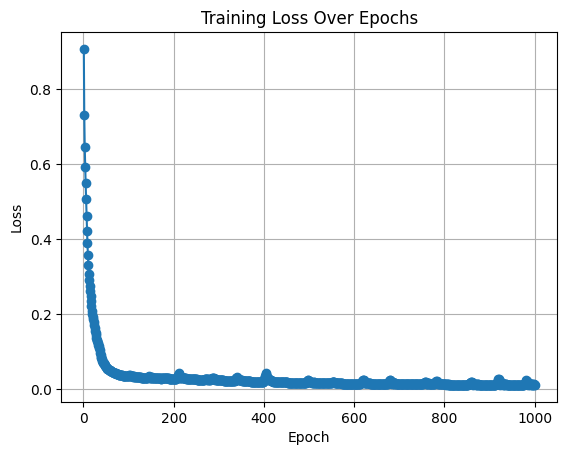

In [ ]:
# Plot loss for Normal Adam
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

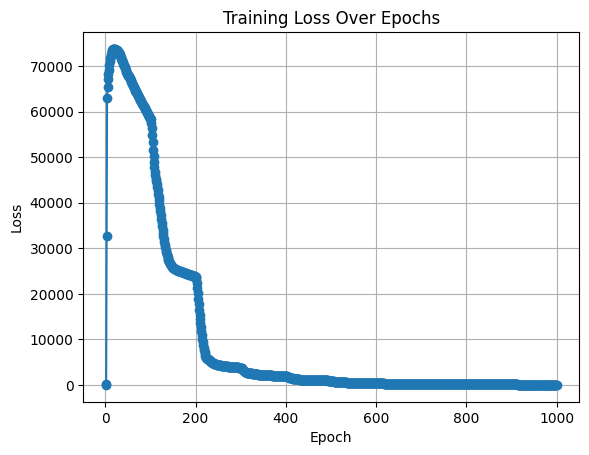

In [ ]:
# Plot loss for Flora
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

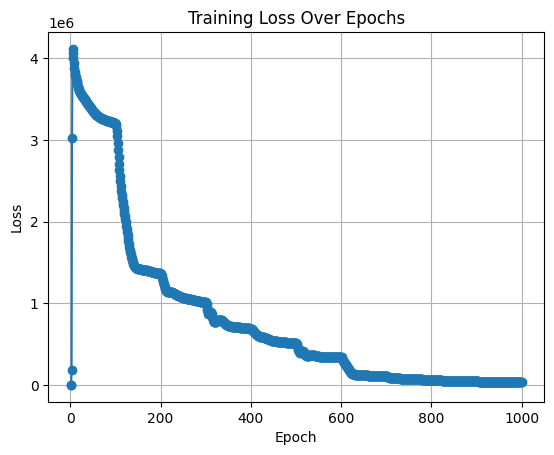

In [ ]:
# Plot loss for Flora Decreasing Ranks
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

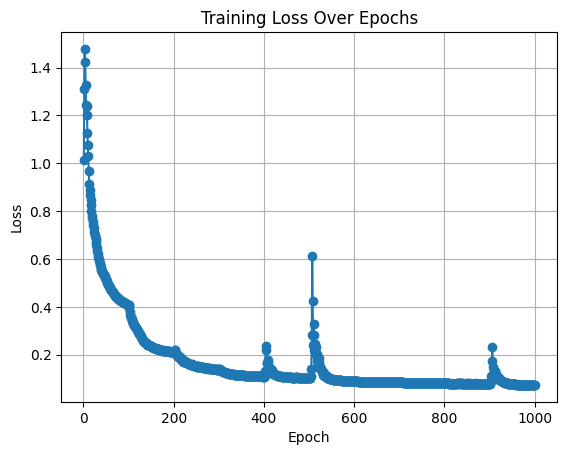

In [18]:
# Plot loss for Flora Factorized MAS
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sample data
texts = ["this is good", "I love it", "horrible experience", "very bad", "excellent job", "not good"]
labels = [1, 1, 0, 0, 1, 0]

# Tokenizer and Vocabulary
special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
tokenizer = lambda x: x.lower().split()

# Build vocab
word_set = set()
for sentence in texts:
    word_set.update(tokenizer(sentence))

word2idx = {word: idx + len(special_tokens) for idx, word in enumerate(sorted(word_set))}
for idx, token in enumerate(special_tokens):
    word2idx[token] = idx

idx2word = {idx: word for word, idx in word2idx.items()}

PAD_IDX = word2idx["<pad>"]
SOS_IDX = word2idx["<sos>"]
EOS_IDX = word2idx["<eos>"]
VOCAB_SIZE = len(word2idx)

def encode(text):
    return [SOS_IDX] + [word2idx.get(word, word2idx["<unk>"]) for word in tokenizer(text)] + [EOS_IDX]

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.sequences = [torch.tensor(encode(text), dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def pad_collate(batch):
    sequences, labels = zip(*batch)
    padded_seqs = nn.utils.rnn.pad_sequence(sequences, padding_value=PAD_IDX, batch_first=True)
    return padded_seqs, torch.tensor(labels)

# Transformer Model with Encoder + Decoder
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.positional = nn.Parameter(torch.randn(1, 100, embed_dim))  # learnable position encoding

        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim)
        decoder_layer = nn.TransformerDecoderLayer(embed_dim, num_heads, ff_dim)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, src):
        emb = self.embedding(src) + self.positional[:, :src.size(1), :]
        emb = emb.transpose(0, 1)  # [seq_len, batch, embed_dim]

        memory = self.encoder(emb)
        output = self.decoder(emb, memory)
        pooled = output.mean(dim=0)  # mean over sequence
        return self.fc(pooled)

# Training
EMBED_DIM = 320
NUM_HEADS = 10
FF_DIM = 64
NUM_CLASSES = 2
EPOCHS = 10
BATCH_SIZE = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

model = TransformerClassifier(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, FF_DIM, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = FloraAdamFactored(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
optimizer = FloraAdamFactoredMAS(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 2.1757
Epoch 2: Loss = 1.6892
Epoch 3: Loss = 1.1420
Epoch 4: Loss = 0.9334
Epoch 5: Loss = 0.3962
Epoch 6: Loss = 0.2035
Epoch 7: Loss = 0.0358
Epoch 8: Loss = 0.0106
Epoch 9: Loss = 0.0024
Epoch 10: Loss = 0.0014


In [ ]:
for i in (list(model.named_parameters())):
  print(i[0], i[1].shape)

positional torch.Size([1, 100, 320])
embedding.weight torch.Size([17, 320])
encoder.layers.0.self_attn.in_proj_weight torch.Size([960, 320])
encoder.layers.0.self_attn.in_proj_bias torch.Size([960])
encoder.layers.0.self_attn.out_proj.weight torch.Size([320, 320])
encoder.layers.0.self_attn.out_proj.bias torch.Size([320])
encoder.layers.0.linear1.weight torch.Size([64, 320])
encoder.layers.0.linear1.bias torch.Size([64])
encoder.layers.0.linear2.weight torch.Size([320, 64])
encoder.layers.0.linear2.bias torch.Size([320])
encoder.layers.0.norm1.weight torch.Size([320])
encoder.layers.0.norm1.bias torch.Size([320])
encoder.layers.0.norm2.weight torch.Size([320])
encoder.layers.0.norm2.bias torch.Size([320])
decoder.layers.0.self_attn.in_proj_weight torch.Size([960, 320])
decoder.layers.0.self_attn.in_proj_bias torch.Size([960])
decoder.layers.0.self_attn.out_proj.weight torch.Size([320, 320])
decoder.layers.0.self_attn.out_proj.bias torch.Size([320])
decoder.layers.0.multihead_attn.in_pr